In [1]:
import pandas as pd
import tarfile
import os

#important libraries for the Sentiment analysis
from scipy.signal import savgol_filter
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#important libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

from typing import Dict
import json
import re

Since our research focuses on the impact of terrorism on movies, we need to filter the dataset using a list of specific keywords found on Wikipedia.

In [2]:
KEYWORDS = [ "Terrorism", "Terrorist", "Terrorists", "Jihad", "Extremism", "Extremist", "Attacks", "Attack", "Bombs", "Bombing", "Bombers", 
            "Hijack", "Hijacking", "Kidnap", "Kidnapping", "Counterterrorism", "Counterterrorist", "Radicalization", "Radicalized", 
            "Security Threat", "Political Violence", "Suicide Bomber", "War on Terror", "Homeland Security", "National Security", "Intelligence Agencies", 
            "Counterinsurgency", "Terrorist Cells", "Radical Ideology", "Terrorist Plot", "Terrorist Organization", "Hostage Crisis", "Terrorism Investigation", 
            "Counterterrorist Operation", "Radical", "Guerrilla Warfare", "Insurgency", "Terror Threat", "Covert Operations", "Political Unrest", "Martyrdom", 
            "Cyberterrorism", "Terrorism Financing", "Violent Extremism", "Terrorist Recruitment", "Suicide Attacks", "Terrorist Sleeper Cells", 
            "Counterterror Measures", "Clandestine Activities", "Security Intelligence" ]

In [3]:
# Define the path to your text file containing movie plots
file_path = 'data/plot_summaries.txt'

# Read the text file into a DataFrame
df_summaries = pd.read_csv(file_path, delimiter='\t', header= None)

movie_ids=[]
# Create a new column in the DataFrame to store the count of keywords in each movie plot
for index, row in df_summaries.iterrows():
    movie_id = row[0]
    plot = row[1]
    # Check if the plot contains any of the keywords
    for keyword in KEYWORDS:
        if keyword.lower() in plot:
            movie_ids.append(movie_id)

# Display the list of movie IDs that match the keywords
movie_ids= set(movie_ids)

In [4]:
#import the data from movie.metadata and rename its columns
column_names = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Release date', 'Box office revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
movies_data = pd.read_csv('data/movie.metadata.tsv', delimiter= '\t',on_bad_lines='skip', names=column_names, header=0)

In [5]:
# Filter the movies_data DataFrame to include only the rows with IDs that are present in the movie_ids list
filtered_data = movies_data[movies_data['Wikipedia movie ID'].isin(movie_ids)][['Wikipedia movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]
filtered_data = filtered_data.sort_values(by=['Release date'])
display(filtered_data)

,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue
42214,32986669,Robbery Under Arms,1907-11-02,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",NaN
64189,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
70994,29391146,The Black Viper,1908-07-25,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film""}",NaN
18652,28777800,The Englishman and the Girl,1910-02-17,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
45311,13254122,What the Daisy Said,1910-07-11,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
...,...,...,...,...,...,...,...
81156,11971266,La Guerre des tuques,NaN,"{""/m/0d060g"": ""Canada""}","{""/m/064_8sq"": ""French Language""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/0hj3mt...",NaN
81303,11515305,Buio Omega,NaN,"{""/m/03rjj"": ""Italy""}","{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/03npn"": ""Horror""}",NaN
81312,27613497,Emperor: Young Caesar,NaN,{},{},"{""/m/06l3bl"": ""Epic""}",NaN
81340,27646962,Raging Sharks,NaN,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/02h40lc"": ""English Language""}","{""/m/03npn"": ""Horror""}",NaN


In [6]:
df_summaries.columns = ['Wikipedia movie ID', 'Plot Summary']

In [7]:
#Merge filtered_data with movies_data
df_terrorism_summaries = pd.merge(filtered_data, df_summaries, on='Wikipedia movie ID')
df_terrorism_summaries

,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary
0,32986669,Robbery Under Arms,1907-11-02,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",NaN,Key scenes of the film included the branding o...
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN,Dr. Jekyll and Mr. Hyde began with the raising...
2,29391146,The Black Viper,1908-07-25,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film""}",NaN,A thug accosts a girl as she leaves her workpl...
3,28777800,The Englishman and the Girl,1910-02-17,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN,A small town's drama group is preparing for a ...
4,13254122,What the Daisy Said,1910-07-11,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN,Two farm sisters are feeling romantic and loo...
...,...,...,...,...,...,...,...,...
8621,11971266,La Guerre des tuques,NaN,"{""/m/0d060g"": ""Canada""}","{""/m/064_8sq"": ""French Language""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/0hj3mt...",NaN,The film involves a huge snowball fight betwee...
8622,11515305,Buio Omega,NaN,"{""/m/03rjj"": ""Italy""}","{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/03npn"": ""Horror""}",NaN,"Anna Völkl, the fiance of taxidermist Frank Wy..."
8623,27613497,Emperor: Young Caesar,NaN,{},{},"{""/m/06l3bl"": ""Epic""}",NaN,The film will attempt to adapt the first two n...
8624,27646962,Raging Sharks,NaN,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/02h40lc"": ""English Language""}","{""/m/03npn"": ""Horror""}",NaN,"In the opening, a collision between two alien ..."


When displaying the dataframe, we notice that the columns Countries, Languages and Genres include some kind of ID, in addition to the readable value we are interest in (for example {"/m/0chghy": "Australia"}). To get a more visually pleasing dataframe, we use the JSON library as follows.

In [8]:
# Function to extract the readable values from the strings
def extract_values(text):
    try:
        # Load the text as JSON and extract values
        data_dict = json.loads(text)
        return ', '.join(data_dict.values())
    except json.JSONDecodeError:
        # If it's not valid JSON, try to find all readable parts with regex
        return ', '.join(re.findall(r'":\s*"([^"]+)"', text))

# Apply the function to clean the columns of our dataframe
df_terrorism_summaries['Countries'] = df_terrorism_summaries['Countries'].apply(extract_values)
df_terrorism_summaries['Languages'] = df_terrorism_summaries['Languages'].apply(extract_values)
df_terrorism_summaries['Genres'] = df_terrorism_summaries['Genres'].apply(extract_values)
df_terrorism_summaries

,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",NaN,Key scenes of the film included the branding o...
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",NaN,Dr. Jekyll and Mr. Hyde began with the raising...
2,29391146,The Black Viper,1908-07-25,United States of America,Silent film,Silent film,NaN,A thug accosts a girl as she leaves her workpl...
3,28777800,The Englishman and the Girl,1910-02-17,United States of America,"Silent film, English Language","Short Film, Silent film, Comedy",NaN,A small town's drama group is preparing for a ...
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",NaN,Two farm sisters are feeling romantic and loo...
...,...,...,...,...,...,...,...,...
8621,11971266,La Guerre des tuques,NaN,Canada,French Language,"Children's/Family, Animal Picture, Comedy-dram...",NaN,The film involves a huge snowball fight betwee...
8622,11515305,Buio Omega,NaN,Italy,"Italian Language, English Language",Horror,NaN,"Anna Völkl, the fiance of taxidermist Frank Wy..."
8623,27613497,Emperor: Young Caesar,NaN,,,Epic,NaN,The film will attempt to adapt the first two n...
8624,27646962,Raging Sharks,NaN,"United States of America, Bulgaria",English Language,Horror,NaN,"In the opening, a collision between two alien ..."


# 4)How do movies emotionally depict terrorism, and are there identifiable patterns in the portrayal of emotions like fear, anger, empathy, or sadness? Additionally, do the emotional tones in the cinematic representation of terrorism differ between specific countries/regions?

**Data wrangling for the Sentiment analysis:**

Once we have obtained our movie summaries, based on the list of keywords we defined, we start the data preprocessing for the sentiment analysis, the first step of which is to **tokenize** the sentences present in each movie plot. In other words, we split the summaries in separate senetences using the NTLK (natural language processing) library.
Different approaches are available for tokenization:   
- Splitting text into separate sentences (`nltk.tokenize.sent_tokenize`)  
- Splliting text into seprarate words (`nltk.tokenize.word_tokenize`).  

We chose to use the first approach, as it is more suitable for our analysis. Indeed, keeping the full sentence is important in sentiment analysis since the sentiment often depends strongly on how words are put together rather than individual words. For example, the sentence "I love this movie" has a positive sentiment, while "I do not love this movie" has a negative sentiment, even though both sentences contain the word "love".
     
After splitting the summaries into sentences, we convert all the words to lowercase, so that the words "Love", "LOVE" and "love" are all considered as the same word. 

In [9]:
#NLTK often requires some additional data to be downloaded before it can be used effectively. 
#This data includes pre-trained models, corpora, and other resources that NLTK uses to perform various NLP tasks.
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    |

True

In [10]:
# Splitting the text into individual sentences
df_terrorism_summaries['summaries_tokens']= df_terrorism_summaries['Plot Summary'].apply(lambda s: tokenize.sent_tokenize(s))
df_terrorism_summaries.head()

,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary,summaries_tokens
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",NaN,Key scenes of the film included the branding o...,[Key scenes of the film included the branding ...
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",NaN,Dr. Jekyll and Mr. Hyde began with the raising...,[Dr. Jekyll and Mr. Hyde began with the raisin...
2,29391146,The Black Viper,1908-07-25,United States of America,Silent film,Silent film,NaN,A thug accosts a girl as she leaves her workpl...,[A thug accosts a girl as she leaves her workp...
3,28777800,The Englishman and the Girl,1910-02-17,United States of America,"Silent film, English Language","Short Film, Silent film, Comedy",NaN,A small town's drama group is preparing for a ...,[A small town's drama group is preparing for a...
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",NaN,Two farm sisters are feeling romantic and loo...,[Two farm sisters are feeling romantic and lo...


In [11]:
# Converting to lower case
df_terrorism_summaries['summaries_tokens'] = df_terrorism_summaries['summaries_tokens'].apply(lambda x: [word.lower() for word in x])
df_terrorism_summaries.head()

,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary,summaries_tokens
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",NaN,Key scenes of the film included the branding o...,[key scenes of the film included the branding ...
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",NaN,Dr. Jekyll and Mr. Hyde began with the raising...,[dr. jekyll and mr. hyde began with the raisin...
2,29391146,The Black Viper,1908-07-25,United States of America,Silent film,Silent film,NaN,A thug accosts a girl as she leaves her workpl...,[a thug accosts a girl as she leaves her workp...
3,28777800,The Englishman and the Girl,1910-02-17,United States of America,"Silent film, English Language","Short Film, Silent film, Comedy",NaN,A small town's drama group is preparing for a ...,[a small town's drama group is preparing for a...
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",NaN,Two farm sisters are feeling romantic and loo...,[two farm sisters are feeling romantic and lo...


**Sentiment analysis:**

Now that the text preprocessing is completed, we can perform the sentiment analysis on the different sentences. Our analysis will be split into 2 parts:  
- **General sentiment analysis:** We are going to use `VaderSentimentAnalyzer`, which is a popular tool usually used to analyze social media content;it is used for informal and short text. We will apply it on every sentence to obtain a sentiment score between -1 (for negative sentences) and 1 (for positive sentences) in the continuous case. For the discrete case, we have 3 possibilities: -1: negative, 0: neutral, 1: positive.     
- **Emotion classification:** VADER is mostly used for general sentiment analysis (positive, neutral, negative) but is limited when it comes to more complex emotions such as fear or terror.  
We will therefore use more specialized libraries like **Deepmoji**. Deepmoji is a deep-learning model developed by MIT researchers and trained on 1.2 billion tweets, that can recognize 64 different emotions. We can also use a pre-trained model such as **Bert**, available in the transformers library. Bert is a  model that can recognize 13 different emotions. We will try to implement both methods and decide which one is the most suitable for our analysis.

**Step1: General sentiment analysis with VADER**

In [12]:
# Initialize the analyzer
analyzer = SentimentIntensityAnalyzer()

# classifying into 3 classes (positive, negative, neutral)
def classify(score: float):
    #positive
    if score >= 0.05:
        return 1
    #negative
    elif score <= -0.05:
        return -1
    #neutral
    return 0

# given a list of sentences, the function returns the result of the analyzer
def analyse_text(text, classify_discrete = True): 
    res = []
    for sentence in text:
        sentiment_result = analyzer.polarity_scores(sentence)
        if classify_discrete:
            res.append(classify(sentiment_result['compound']))
        else:
            res.append(sentiment_result['compound'])
    
    window = int(len(res)/6)
    window = window + 1 if window%2 == 0 else window 
    
    # we utilize a savgol filter, which will smooth the time series (without filtering the resultant time series might be noisy.)
    return savgol_filter(res, window_length=window, polyorder=3) if (not classify_discrete and window>3) else res

We compute the plot sentiment discrete classes and continuous scores (the two different columns described previously).

In [14]:
# analyse_text performs sentiment analysis and returns a discrete sentiment class (e.g., positive, negative, neutral).
df_terrorism_summaries["summaries_classification"] = df_terrorism_summaries["summaries_tokens"].apply(lambda s: analyse_text(s))
#Similar to the above, but this 'analyse_text' function is expected to return a continuous score,
# likely a number that represents the sentiment strength (e.g., a score from -1 to 1 where -1 is very negative and 1 is very positive).
df_terrorism_summaries["summaries_scores_per_sentence"] = df_terrorism_summaries["summaries_tokens"].apply(lambda s: analyse_text(s, classify_discrete=False))
# Calculate the mean sentiment score for each movie plot
#df_terrorism_summaries["mean_sentiment_score"] = df_terrorism_summaries["sentiment_scores_per_sentence"].apply(lambda scores: np.mean(scores))
# Calculate the number of sentences in each summary.
df_terrorism_summaries["number_of_sentences"] = df_terrorism_summaries["summaries_tokens"].apply(lambda s: len(s))

In [15]:
# display the first 5 elements to view the newly added columns 
df_terrorism_summaries.head(5)

,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary,summaries_tokens,summaries_classification,summaries_scores_per_sentence,number_of_sentences
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",NaN,Key scenes of the film included the branding o...,[key scenes of the film included the branding ...,"[-1, 0, 0]","[-0.9118, 0.0, 0.0]",3
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",NaN,Dr. Jekyll and Mr. Hyde began with the raising...,[dr. jekyll and mr. hyde began with the raisin...,"[0, 1, -1, 1, -1, 1]","[0.0, 0.6369, -0.6486, 0.4404, -0.9657, 0.7506]",6
2,29391146,The Black Viper,1908-07-25,United States of America,Silent film,Silent film,NaN,A thug accosts a girl as she leaves her workpl...,[a thug accosts a girl as she leaves her workp...,"[1, -1, 1, 1, -1]","[0.4497, -0.128, 0.4939, 0.4019, -0.7845]",5
3,28777800,The Englishman and the Girl,1910-02-17,United States of America,"Silent film, English Language","Short Film, Silent film, Comedy",NaN,A small town's drama group is preparing for a ...,[a small town's drama group is preparing for a...,"[1, 1, -1, -1]","[0.34, 0.8225, -0.3743, -0.705]",4
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",NaN,Two farm sisters are feeling romantic and loo...,[two farm sisters are feeling romantic and lo...,"[1, 1, -1, 1, 0, -1, 1]","[0.4939, 0.34, -0.3182, 0.128, 0.0, -0.8885, 0...",7


Since the pie-chart is too dense, we choose to group the movies co-produced by several countries. We keep the n most represented countries in the visualisation. 

In [28]:
#Removing the NaN values from the Countries column
df_terrorism_summaries = df_terrorism_summaries[df_terrorism_summaries['Countries'] != '']

exploded = df_terrorism_summaries.explode('Countries')

In [29]:
def plot_interactive_pie(df, column, title, n):
    counts = df[column].value_counts()
    # Keep the top n and sum the rest under "Others"
    top_counts = counts[:n]
    top_counts['Others'] = counts[n:].sum()
    fig = px.pie(values=top_counts, names=top_counts.index, title=title)
    fig.update_traces(textinfo='percent+label')
    fig.show()
plot_interactive_pie(exploded, 'Countries', 'Percentage of Movies on terrorism per Country', 5)


We also try a bar chart to visualise the same information.

In [19]:
def plot_top_n_countries(df, column, n, title):
    counts = df[column].value_counts()
    # Keep the top n and sum the rest under "Others"
    top_counts = counts[:n]
    top_counts['Others'] = counts[n:].sum()
    fig = px.bar(x=top_counts.index, y=top_counts.values, title=title)
    #labels
    fig.update_xaxes(title_text='Country')
    fig.update_yaxes(title_text='Number of Movies')
    fig.show()

plot_top_n_countries(df_terrorism_summaries, 'Countries', 5, 'Top Countries in Movie Production')

In [20]:
# Convert the 'Release date' to datetime format if it's not already
df_terrorism_summaries['Release date'] = pd.to_datetime(df_terrorism_summaries['Release date'], errors='coerce')

# Assuming that you have cleaned your data and it's ready for plotting
# We'll plot the number of movies by year for a time series analysis
fig_time_series = px.line(
    df_terrorism_summaries.groupby(df_terrorism_summaries['Release date'].dt.year).size().reset_index(name='Count'),
    x='Release date', y='Count',
    labels={'Count': 'Number of Movies', 'Release date': 'Year'},
    title='Number of Movies Released Over Time'
)
fig_time_series.show()


Visualisation proper to the sentiment scores obtained with VADER thusfar.

In [21]:
df_terrorism_summaries['Sentiment Score'] = df_terrorism_summaries['summaries_scores'].apply(lambda x: x[0])

# Create a histogram of sentiment scores
fig = px.histogram(df_terrorism_summaries, x='Sentiment Score', nbins=50, title='Distribution of Sentiment Scores')
fig.show()


KeyError: 'summaries_scores'

In [ ]:
# Create a scatter plot of sentiment scores against the number of sentences
fig = px.scatter(df_terrorism_summaries, x='number_of_sentences', y='Sentiment Score', title='Sentiment Score vs. Number of Sentences')
fig.show()


Movies per country.

In [ ]:
import pycountry
import plotly.graph_objects as go

#to be able to use Plotly's Choropleth map function
def get_iso_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None  # If the country name is not found, return None

# Apply the function to get ISO codes
df_terrorism_summaries['iso_alpha'] = df_terrorism_summaries['Countries'].apply(get_iso_code)

# create a Choropleth map:

# Group by 'iso_alpha' to get the count of movies per country code
movie_counts = df_terrorism_summaries.groupby('iso_alpha').size().reset_index(name='Movie Count')

# Create the Choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=movie_counts['iso_alpha'],  # ISO codes for countries
    z=movie_counts['Movie Count'],  # Data to be color-coded
    text=movie_counts['iso_alpha'],  # Country codes
    colorscale='Viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title='Number of Movies',
))

fig.update_layout(
    title_text='Number of Movies on terrorism by Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)
fig.show()


**Step2: Emotion classification with Bert**

Bert is a Transformer Bidirectional Encoder based Architecture trained on MLM(Mask Language Modeling) objective
bert-base-uncased finetuned on the emotion dataset using HuggingFace Trainer with below training parameters

In [ ]:
import transformers
from transformers import pipeline

ImportError: cannot import name 'get_full_repo_name' from 'huggingface_hub' (/Users/macdesarah/opt/anaconda3/envs/ADA/lib/python3.9/site-packages/huggingface_hub/__init__.py)

In [ ]:
# Initialize a pipeline for emotion detection
emotion_detector = transformers.pipeline('sentiment-analysis', model='bert-base-uncased') 

# Function to predict emotion
def detect_emotion(text):
    result = emotion_detector(text)
    return result

# Applying the function to your dataset
df_terrorism_summaries['emotion'] = df_terrorism_summaries['summaries_tokens'].apply(detect_emotion)

NameError: name 'transformers' is not defined

By hand classification of emotions (before using Bert pre-trained model)

In [ ]:
def has_keyword(summary, keywords):
    for word in keywords:
        if word in summary.lower():  # Perform a case-insensitive check
            return True
    return False

In [ ]:
#sadness emotion
sadness_keywords = [
    'sadness', 'sorrow', 'grief', 'depression', 'despair', 'heartache', 'melancholy', 'misery', 'lament', 'ache',
    'woeful', 'desolate', 'gloomy', 'doleful', 'blue', 'mournful', 'downhearted', 'tragic', 'dejected', 'somber',
    'tearful', 'forlorn', 'heavy-hearted', 'grieving', 'dismal', 'dismay', 'hopeless', 'pain', 'wistful', 'regret',
    'agony', 'disheartened', 'weeping', 'distressed', 'miserable', 'sullen', 'lamentation', 'moody', 'wretched',
    'cheerless', 'sombre', 'funereal', 'grim', 'lugubrious', 'hurt', 'bereaved', 'woe', 'anguished',
    'cheerless', 'gloomy', 'lamentation', 'funereal', 'lugubrious', 'agonized', 'mourn', 'aching'
]
movies = df_terrorism_summaries.copy()
sad_movies = movies[movies['Plot Summary'].apply(lambda x: has_keyword(x, sadness_keywords))]

In [ ]:
print(f"We have {len(sad_movies)} sad movies")

We have 4033 sad movies


In [ ]:
sad_movies.head()

,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary,summaries_tokens,summaries_classification,summaries_scores,number_of_sentences,Categories,Sentiment Score,iso_alpha
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",NaN,Two farm sisters are feeling romantic and loo...,[two farm sisters are feeling romantic and lo...,"[1, 1, -1, 1, 0, -1, 1]","[0.4939, 0.34, -0.3182, 0.128, 0.0, -0.8885, 0...",7,United States of America,0.493900,USA
6,33031395,A Bushranger's Ransom,1911-03-28,Australia,"Silent film, English Language",Silent film,NaN,In 1863 Ben Hall and his men raid the househol...,[in 1863 ben hall and his men raid the househo...,"[-1, -1, 0, 0, 1]","[-0.4767, -0.8271, 0.0, 0.0, 0.4215]",5,Australia,-0.476700,AUS
9,32895091,The Tide of Death,NaT,,"Silent film, English Language",Silent film,NaN,"The film opens with a young mining contractor,...",[the film opens with a young mining contractor...,"[0, -1, 1, 0, 1, 0, 0, 0, -1, 0, 1, 0, 0]","[0.0, -0.5574, 0.4019, 0.0, 0.8047, 0.0, 0.0, ...",13,,0.000000,None
14,32895202,Australia Calls,NaT,,"Silent film, English Language",Silent film,NaN,"The film begins with a prologue, 'The Warning'...","[the film begins with a prologue, 'the warning...","[-1, -1, 0, -1, -1, 1, -1, 0, 0]","[-0.34, -0.4939, 0.0, -0.5423, -0.7783, 0.6705...",9,,-0.340000,None
18,13405420,The Battle at Elderbush Gulch,NaT,United States of America,"Silent film, English Language","Short Film, Silent film, Western, Black-and-wh...",NaN,Sally and her little sister are sent to visit...,[sally and her little sister are sent to visi...,"[0, 0, 0, 1, -1, 0, -1, 0, 0, -1, -1, 1, -1, 0...","[0.019838571428569464, -0.07935428571428635, 0...",24,United States of America,0.019839,USA


In [ ]:
#surprise emotion 
surprise_keywords = [
    'surprise', 'amazement', 'astonishment', 'awe', 'shocked', 'wonder', 'startled', 'stunned', 'astounded', 'shock',
    'dumbfounded', 'jolt', 'unbelievable', 'incredulous', 'stupefied', 'bewildered', 'dazed', 'disbelief', 'astonished',
    'gasp', 'overwhelmed', 'taken aback', 'flabbergasted', 'aghast', 'speechless', 'unforeseen', 'unexpected',
    'astounding', 'incredible', 'mind-blowing', 'eye-opening', 'staggering', 'unexpected', 'surprised', 'unanticipated',
    'sudden', 'wonderment', 'jarring', 'shattering', 'unforeseen', 'stunning', 'stupendous', 'jaw-dropping',
    'awe-inspiring', 'startling', 'impressive', 'extraordinary', 'remarkable', 'unforeseen', 'startling', 'shattering',
    'unpredictable', 'unforeseen', 'awe-struck', 'impressed', 'unplanned', 'amazing', 'suddenness'
]
surprise_movies = movies[movies['Plot Summary'].apply(lambda x: has_keyword(x, surprise_keywords))]

In [ ]:
print(f"We have {len(surprise_movies)} surprise movies")
surprise_movies.head(2)

We have 3189 surprise movies


,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary,summaries_tokens,summaries_classification,summaries_scores,number_of_sentences,Categories,Sentiment Score,iso_alpha
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",NaN,Dr. Jekyll and Mr. Hyde began with the raising...,[dr. jekyll and mr. hyde began with the raisin...,"[0, 1, -1, 1, -1, 1]","[0.0, 0.6369, -0.6486, 0.4404, -0.9657, 0.7506]",6,United States of America,0.00,USA
3,28777800,The Englishman and the Girl,1910-02-17,United States of America,"Silent film, English Language","Short Film, Silent film, Comedy",NaN,A small town's drama group is preparing for a ...,[a small town's drama group is preparing for a...,"[1, 1, -1, -1]","[0.34, 0.8225, -0.3743, -0.705]",4,United States of America,0.34,USA


In [ ]:
#happiness movies
happiness_keywords = [
    'joy', 'happiness', 'delight', 'bliss', 'cheer', 'gladness', 'elation', 'euphoria', 'ecstasy', 'jubilation',
    'triumph', 'contentment', 'satisfaction', 'glee', 'serenity', 'exhilaration', 'merriment', 'enjoyment', 'thrill',
    'felicity', 'euphoric', 'lighthearted', 'overjoyed', 'radiant', 'buoyant', 'elated', 'uplifted', 'sunny', 'joyful',
    'gratification', 'jolly', 'blithe', 'ecstatic', 'spirited', 'zestful', 'carefree', 'vibrant', 'mirth', 'gaiety',
    'pleasure', 'rejoicing', 'entertainment', 'amusement', 'exuberant', 'glad', 'thrilled', 'upbeat', 'pleased',
    'ecstatic', 'mirthful', 'radiant', 'jubilant', 'upbeat', 'contented', 'pleasurable', 'exuberant'
]
happiness_movies = movies[movies['Plot Summary'].apply(lambda x: has_keyword(x, happiness_keywords))]

In [ ]:
print(f"We have {len(happiness_movies)} happiness movies")
happiness_movies.head(2)

We have 2549 happiness movies


,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary,summaries_tokens,summaries_classification,summaries_scores,number_of_sentences,Categories,Sentiment Score,iso_alpha
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",NaN,Dr. Jekyll and Mr. Hyde began with the raising...,[dr. jekyll and mr. hyde began with the raisin...,"[0, 1, -1, 1, -1, 1]","[0.0, 0.6369, -0.6486, 0.4404, -0.9657, 0.7506]",6,United States of America,0.0,USA
9,32895091,The Tide of Death,NaT,,"Silent film, English Language",Silent film,NaN,"The film opens with a young mining contractor,...",[the film opens with a young mining contractor...,"[0, -1, 1, 0, 1, 0, 0, 0, -1, 0, 1, 0, 0]","[0.0, -0.5574, 0.4019, 0.0, 0.8047, 0.0, 0.0, ...",13,,0.0,None


In [ ]:
#fear emotion
fear_keywords = [
    'terror', 'fear', 'fright', 'panic', 'dread', 'horror', 'anxiety', 'worry', 'apprehension', 'trepidation',
    'nervousness', 'scared', 'awe', 'phobia', 'spine-chilling', 'petrified', 'terrified', 'horrified', 'alarmed',
    'startled', 'creepy', 'shivery', 'timid', 'anxious', 'panicky', 'hysteria', 'creeped out', 'jittery', 'dismay',
    'uneasy', 'frightened', 'spooked', 'eerie', 'haunting', 'apprehensive', 'scary', 'chilling', 'menacing',
    'hysterical', 'foreboding', 'tense', 'panic-stricken', 'shocked', 'unnerved', 'terrifying', 'shuddery', 'afraid',
    'unsettled', 'fainthearted', 'cowardly', 'tremulous', 'distressed', 'anxiousness'
]
fear_movies = movies[movies['Plot Summary'].apply(lambda x: has_keyword(x, fear_keywords))]

In [ ]:
print(f"We have {len(fear_movies)} fear movies")
fear_movies.head(2)

We have 3789 fear movies


,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary,summaries_tokens,summaries_classification,summaries_scores,number_of_sentences,Categories,Sentiment Score,iso_alpha
4,13254122,What the Daisy Said,1910-07-11,United States of America,"Silent film, English Language","Short Film, Silent film, Drama, Indie, Black-a...",NaN,Two farm sisters are feeling romantic and loo...,[two farm sisters are feeling romantic and lo...,"[1, 1, -1, 1, 0, -1, 1]","[0.4939, 0.34, -0.3182, 0.128, 0.0, -0.8885, 0...",7,United States of America,0.4939,USA
5,32987279,The Life of Rufus Dawes,NaT,Australia,Silent film,Silent film,NaN,The film was divided into sections: *ENGLAND -...,[the film was divided into sections: *england ...,"[-1, -1, -1, 1, 0, -1, 1, 0, 0, 0]","[-0.8807, -0.4404, -0.34, 0.4215, 0.0, -0.7096...",10,Australia,-0.8807,AUS


In [ ]:
#anger emotion
anger_keywords = [
    'rage', 'fury', 'irate', 'outrage', 'indignation', 'angry', 'enraged', 'wrath', 'hostility', 'fuming',
    'infuriated', 'resentment', 'temper', 'agitated', 'seething', 'vexed', 'frustration', 'riled up', 'livid',
    'annoyed', 'bitterness', 'mad', 'displeasure', 'fuming', 'peeved', 'irritated', 'provoked', 'ticked off', 'riled',
    'irritation', 'disgust', 'repulsion', 'loathing', 'revulsion', 'abhorrence', 'odious', 'repugnance', 'sickened',
    'hate', 'disdain', 'contempt', 'aversion', 'abomination', 'appalled', 'detestation', 'grossed out', 'sickening',
    'horrified', 'abominable', 'discontent', 'hostile', 'vindictive', 'exasperation', 'outraged', 'exasperated', 'disgruntled'
]
anger_movies = movies[movies['Plot Summary'].apply(lambda x: has_keyword(x, anger_keywords))]

In [ ]:
print(f"We have {len(anger_movies)} anger movies")
anger_movies.head(2)

We have 4283 anger movies


,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary,summaries_tokens,summaries_classification,summaries_scores,number_of_sentences,Categories,Sentiment Score,iso_alpha
17,7884497,Dr. Jekyll and Mr. Hyde,1913-03-06,United States of America,English Language,"Short Film, Science Fiction, Horror, Black-and...",NaN,"Dr. Henry Jekyll sends a note to his fiancée,...",[dr. henry jekyll sends a note to his fiancée...,"[1, -1, 1, -1, 0, 1, -1, -1, -1, -1, -1, 0, -1]","[0.4215, -0.4588, 0.631, -0.8176, 0.0, 0.2263,...",13,United States of America,0.4215,USA
23,13420957,McVeagh of the South Seas,1914-11-02,United States of America,"Silent film, English Language","Silent film, Drama, Indie, Black-and-white",NaN,A shipwreck near the Solomon Islands leaves Sa...,[a shipwreck near the solomon islands leaves s...,"[0, -1, -1, -1, -1, -1]","[0.0, -0.4404, -0.1901, -0.5574, -0.4939, -0.7...",6,United States of America,0.0000,USA


In [ ]:
#disgust movies
disgust_keywords = [
    'disgust', 'repulsion', 'loathing', 'revulsion', 'abhorrence', 'odious', 'repugnance', 'sickened', 'hate',
    'disdain', 'contempt', 'aversion', 'abomination', 'appalled', 'detestation', 'grossed out', 'sickening',
    'horrified', 'abominable', 'discontent', 'hostile', 'vindictive', 'exasperation', 'outraged', 'exasperated',
    'disgruntled', 'nausea', 'revolted', 'yucky', 'offensive', 'displeasure', 'repellent', 'rancid', 'vile',
    'despicable', 'dislike', 'repelling', 'icky', 'turn-off', 'disapproving', 'aberrant', 'foul', 'atrocious',
    'disgusting', 'despise', 'unpleasant', 'repellent', 'revolting', 'loathsome', 'abhorrent', 'off-putting',
    'revolting', 'contemptible', 'abominate', 'disinclined', 'abhor', 'distasteful', 'outrageous', 'fetid',
    'unpalatable', 'frightful', 'sickening', 'vomitous', 'heinous', 'horrifying', 'appalling', 'disgustful'
]
disgust_movies = movies[movies['Plot Summary'].apply(lambda x: has_keyword(x, disgust_keywords))]

In [ ]:
print(f"We have {len(disgust_movies)} disgust movies")
disgust_movies.head(2)

We have 1700 disgust movies


,Wikipedia movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue,Plot Summary,summaries_tokens,summaries_classification,summaries_scores,number_of_sentences,Categories,Sentiment Score,iso_alpha
12,35492984,Call of the Bush,1912-12-12,Australia,"Silent film, English Language","Thriller, Silent film, Drama",NaN,"The film was billed as ""a story of the Austral...","[the film was billed as ""a story of the austra...","[1, 1, 0]","[0.4404, 0.7506, 0.0]",3,Australia,0.4404,AUS
17,7884497,Dr. Jekyll and Mr. Hyde,1913-03-06,United States of America,English Language,"Short Film, Science Fiction, Horror, Black-and...",NaN,"Dr. Henry Jekyll sends a note to his fiancée,...",[dr. henry jekyll sends a note to his fiancée...,"[1, -1, 1, -1, 0, 1, -1, -1, -1, -1, -1, 0, -1]","[0.4215, -0.4588, 0.631, -0.8176, 0.0, 0.2263,...",13,United States of America,0.4215,USA


Text(0.04, 0.5, 'Sentiment Value')

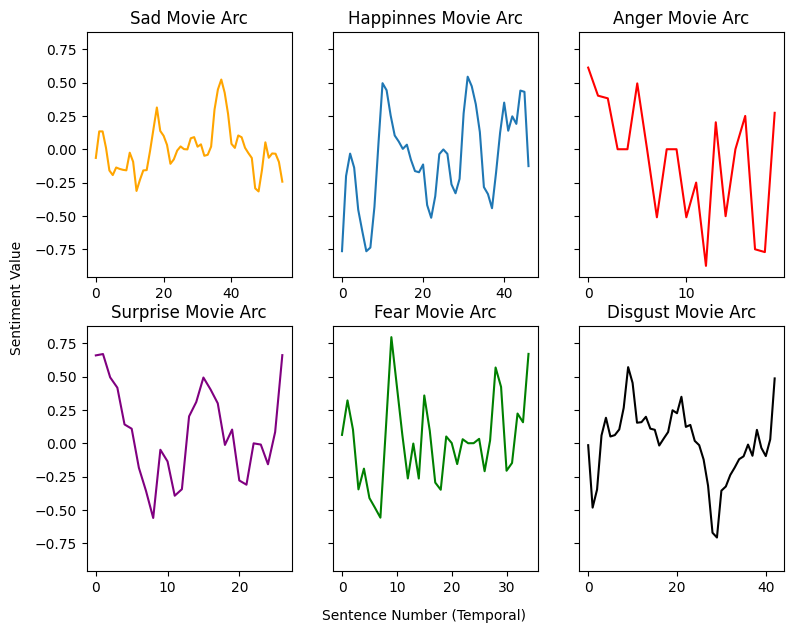

In [ ]:
# now let us visualize different movie arcs for each genre (a sample from each)
fig, axis = plt.subplots(2,3, figsize=(9,7), sharey=True)
# plot the random movie arc
axis[0,0].plot(list(sad_movies.iloc[67]["summaries_scores"]), color="orange")
axis[0,0].set_title("Sad Movie Arc")

axis[0,1].plot(list(happiness_movies.iloc[88]["summaries_scores"]))
axis[0,1].set_title("Happinnes Movie Arc")

axis[1,0].plot(list(surprise_movies.iloc[12]["summaries_scores"]), color="purple")
axis[1,0].set_title("Surprise Movie Arc")

axis[1,1].plot(list(fear_movies.iloc[10]["summaries_scores"]), color="green")
axis[1,1].set_title("Fear Movie Arc")

axis[0,2].plot(list(anger_movies.iloc[67]["summaries_scores"]), color="red")
axis[0,2].set_title("Anger Movie Arc")

axis[1,2].plot(list(disgust_movies.iloc[7]["summaries_scores"]), color="black")
axis[1,2].set_title("Disgust Movie Arc")

fig.text(0.5, 0.04, "Sentence Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

In [ ]:
#We need to find a way to extract the genres
len(df_terrorism_summaries["Movie genres"].unique())

KeyError: 'Movie genres'